<a href="https://colab.research.google.com/github/cnsqhde/Test/blob/main/Kaggle_code_20204005_LeeJunHo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 다운로드 및 저장

In [ ]:
# Token 파일 업로드
# Chrome에서 쿠기 차단풀어둬야함

!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leejunho20204005","key":"560c3ca6353c10c8faa0cb7859761dbb"}'}

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch import nn

import pandas as pd
import numpy as np

import seaborn as sns
import os
import missingno as msno

from collections import Counter

# 경고 안나오도록함
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 파일 업로드 되었는지 확인
!ls -1ha kaggle.json

kaggle.json


In [ ]:
# json 파일 이동
# Kaggle API를 사용하기위해 json 파일을 ~/.kaggle로 이동

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 (read,write 가능하도록 권한 변경)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 데이터셋 불러오기
!kaggle competitions download -c gisthouseprice2021

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 70.8MB/s]
  0% 0.00/435k [00:00<?, ?B/s]
100% 435k/435k [00:00<00:00, 105MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 65.5MB/s]


In [ ]:
!unzip price_data_tr.csv.zip

Archive:  price_data_tr.csv.zip
  inflating: price_data_tr.csv       


In [ ]:
# 파일 unzip 되었는지 확인

os.listdir("../content")

['.config',
 'price_data_ts.csv',
 'price_data_tr.csv',
 'kaggle.json',
 'price_data_val.csv',
 'price_data_tr.csv.zip',
 'sample_data']

In [ ]:
train_data = pd.read_csv("../content/price_data_tr.csv")
test_data = pd.read_csv("../content/price_data_ts.csv")
val_data = pd.read_csv("../content/price_data_val.csv")

# 2. 데이터 분포 파악 및 가공

In [ ]:
train_data.shape, val_data.shape, val_data.shape
# train data는 12968개의 row, 21개의 Column으로 구성
# val_data는 4323개의 row, 21개의 Column으로 구성
# test data는 4323개의 row, 21개의 Column으로 구성

((12968, 21), (4323, 21), (4323, 21))

In [ ]:
# Train data의 data type 확인
# date 파일만 object // 나머지는 int or float data

print(train_data.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [ ]:
# date와 나머지 features로 나눠놓음

date = train_data.dtypes[train_data.dtypes == "object"].index 
print("Number of object features: ", len(date))
print(date)

print(' ')
print('*'*80)
print(' ')

features = train_data.dtypes[train_data.dtypes != "object"].index
print("Number of other features: ", len(features))
print(features)

Number of object features:  1
Index(['date'], dtype='object')
 
********************************************************************************
 
Number of other features:  20
Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
# 이상치 탐색 및 제거

def detect_outliers(data, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index 
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop = detect_outliers(train_data, 2,
                                   ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                                   'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                   'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
                                   'sqft_living15', 'sqft_lot15'])

Outliers_to_drop = detect_outliers(val_data, 2,
                                   ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                                   'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                   'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
                                   'sqft_living15', 'sqft_lot15'])

In [ ]:
# 결측치 확인 (빠져있는 정보 확인)

for col in train_data.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 
              100 * (train_data[col].isnull().sum() / train_data[col].shape[0]))
    print(msperc)

column:         id	 Percent of NaN value: 0.00%
column:       date	 Percent of NaN value: 0.00%
column:      price	 Percent of NaN value: 0.00%
column:   bedrooms	 Percent of NaN value: 0.00%
column:  bathrooms	 Percent of NaN value: 0.00%
column: sqft_living	 Percent of NaN value: 0.00%
column:   sqft_lot	 Percent of NaN value: 0.00%
column:     floors	 Percent of NaN value: 0.00%
column: waterfront	 Percent of NaN value: 0.00%
column:       view	 Percent of NaN value: 0.00%
column:  condition	 Percent of NaN value: 0.00%
column:      grade	 Percent of NaN value: 0.00%
column: sqft_above	 Percent of NaN value: 0.00%
column: sqft_basement	 Percent of NaN value: 0.00%
column:   yr_built	 Percent of NaN value: 0.00%
column: yr_renovated	 Percent of NaN value: 0.00%
column:    zipcode	 Percent of NaN value: 0.00%
column:        lat	 Percent of NaN value: 0.00%
column:       long	 Percent of NaN value: 0.00%
column: sqft_living15	 Percent of NaN value: 0.00%
column: sqft_lot15	 Percent of 

In [ ]:
# 결측치 확인 (빠져있는 정보 확인)
for col in val_data.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 
              100 * (val_data[col].isnull().sum() / val_data[col].shape[0]))
    print(msperc)

column:         id	 Percent of NaN value: 0.00%
column:       date	 Percent of NaN value: 0.00%
column:      price	 Percent of NaN value: 0.00%
column:   bedrooms	 Percent of NaN value: 0.00%
column:  bathrooms	 Percent of NaN value: 0.00%
column: sqft_living	 Percent of NaN value: 0.00%
column:   sqft_lot	 Percent of NaN value: 0.00%
column:     floors	 Percent of NaN value: 0.00%
column: waterfront	 Percent of NaN value: 0.00%
column:       view	 Percent of NaN value: 0.00%
column:  condition	 Percent of NaN value: 0.00%
column:      grade	 Percent of NaN value: 0.00%
column: sqft_above	 Percent of NaN value: 0.00%
column: sqft_basement	 Percent of NaN value: 0.00%
column:   yr_built	 Percent of NaN value: 0.00%
column: yr_renovated	 Percent of NaN value: 0.00%
column:    zipcode	 Percent of NaN value: 0.00%
column:        lat	 Percent of NaN value: 0.00%
column:       long	 Percent of NaN value: 0.00%
column: sqft_living15	 Percent of NaN value: 0.00%
column: sqft_lot15	 Percent of 

In [ ]:
# 결측치 확인 (빠져있는 정보 확인)
for col in test_data.columns: 
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 
              100 * (test_data[col].isnull().sum() / test_data[col].shape[0]))
    print(msperc)

column:         id	 Percent of NaN value: 0.00%
column:       date	 Percent of NaN value: 0.00%
column:      price	 Percent of NaN value: 100.00%
column:   bedrooms	 Percent of NaN value: 0.00%
column:  bathrooms	 Percent of NaN value: 0.00%
column: sqft_living	 Percent of NaN value: 0.00%
column:   sqft_lot	 Percent of NaN value: 0.00%
column:     floors	 Percent of NaN value: 0.00%
column: waterfront	 Percent of NaN value: 0.00%
column:       view	 Percent of NaN value: 0.00%
column:  condition	 Percent of NaN value: 0.00%
column:      grade	 Percent of NaN value: 0.00%
column: sqft_above	 Percent of NaN value: 0.00%
column: sqft_basement	 Percent of NaN value: 0.00%
column:   yr_built	 Percent of NaN value: 0.00%
column: yr_renovated	 Percent of NaN value: 0.00%
column:    zipcode	 Percent of NaN value: 0.00%
column:        lat	 Percent of NaN value: 0.00%
column:       long	 Percent of NaN value: 0.00%
column: sqft_living15	 Percent of NaN value: 0.00%
column: sqft_lot15	 Percent o

In [ ]:
# 비대칭도 (Skewness, 0보다 작으면 오른쪽으로 치우침 // 0보다 크면 오른쪽으로 치우침 )
# 첨도 (Kurtosis, 0보다 클수록 뽀족함) 확인

for col in features: 
  print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(train_data[col].skew()) ,
        ' ' , 'Kurtosis: {:06.2f}'.format(train_data[col].kurt()) )

id              Skewness: 00.25   Kurtosis: -01.26
price           Skewness: 04.03   Kurtosis: 035.16
bedrooms        Skewness: 00.46   Kurtosis: 001.44
bathrooms       Skewness: 00.54   Kurtosis: 001.49
sqft_living     Skewness: 01.48   Kurtosis: 005.42
sqft_lot        Skewness: 14.40   Kurtosis: 352.00
floors          Skewness: 00.60   Kurtosis: -00.50
waterfront      Skewness: 11.26   Kurtosis: 124.74
view            Skewness: 03.41   Kurtosis: 010.94
condition       Skewness: 01.06   Kurtosis: 000.53
grade           Skewness: 00.75   Kurtosis: 001.07
sqft_above      Skewness: 01.44   Kurtosis: 003.37
sqft_basement   Skewness: 01.54   Kurtosis: 002.34
yr_built        Skewness: -0.47   Kurtosis: -00.65
yr_renovated    Skewness: 04.53   Kurtosis: 018.51
zipcode         Skewness: 00.40   Kurtosis: -00.87
lat             Skewness: -0.49   Kurtosis: -00.67
long            Skewness: 00.91   Kurtosis: 001.23
sqft_living15   Skewness: 01.13   Kurtosis: 001.70
sqft_lot15      Skewness: 10.35

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'bathrooms', 'view', 'bedrooms', 'sqft_basement', 'lat', 'waterfront',
       'floors', 'yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built',
       'condition', 'long', 'id', 'zipcode'],
      dtype='object')


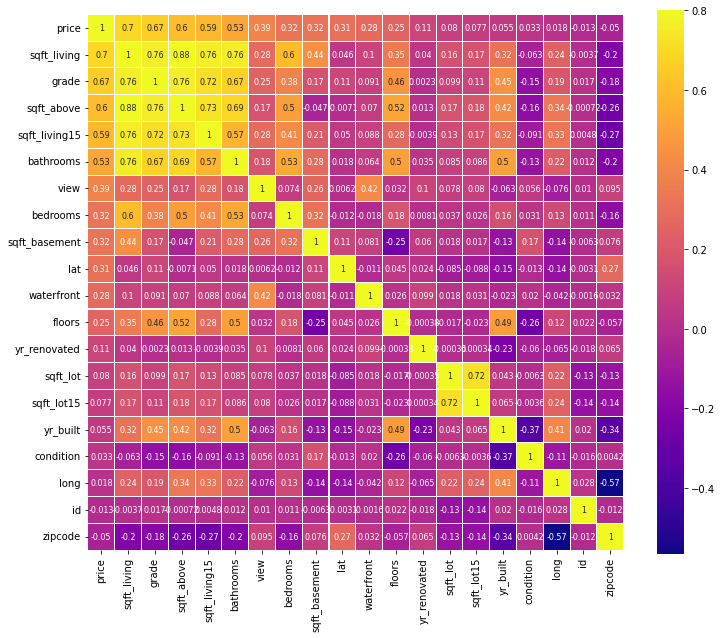

In [ ]:
# Zoomed Heat Map (변수 간 상관관계를 수치화하여 보여줌)
corr_data = train_data[['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                      'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
                      'sqft_living15', 'sqft_lot15']]
                      
colormap = plt.cm.plasma
k= 21
cols = corr_data.corr().nlargest(k,'price')['price'].index
print(cols)
cm = np.corrcoef(train_data[cols].values.T)
f , ax = plt.subplots(figsize = (12,10))

sns.heatmap(cm, vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap,
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':8},yticklabels = cols.values)

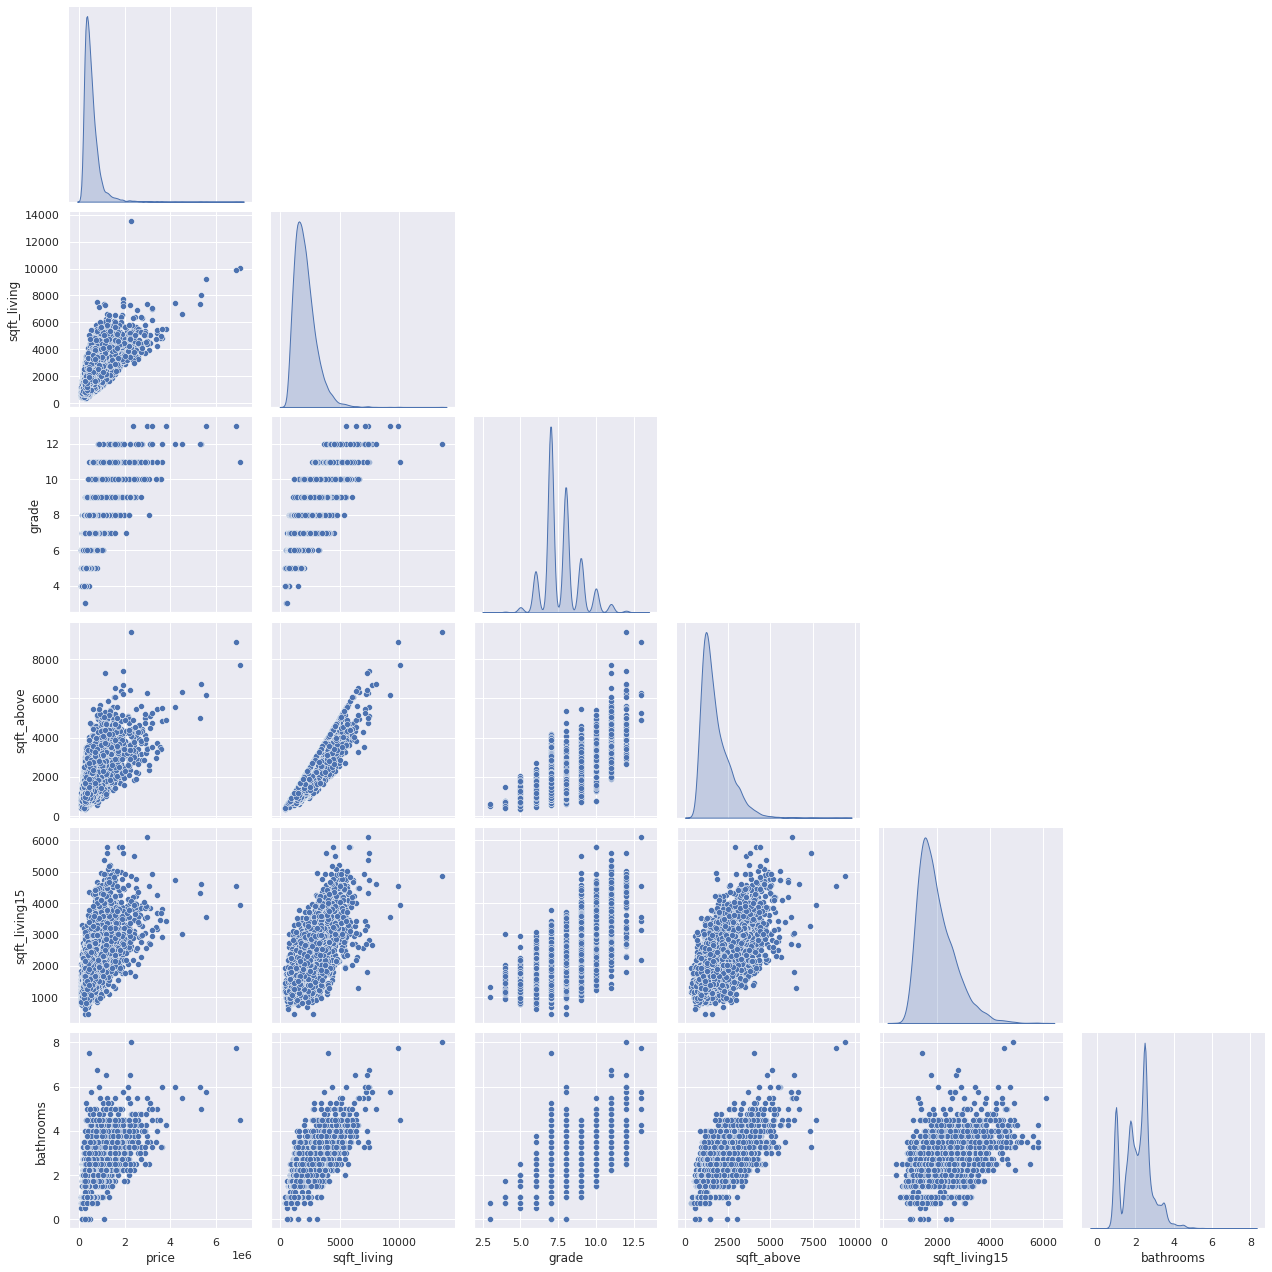

In [ ]:
# Paid plot (연관성이 높은 변수와의 관계를 볼 수 있음)

sns.set()
columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
           'sqft_living15', 'sqft_lot15']
g = sns.pairplot(train_data[columns],size = 3 ,kind ='scatter',diag_kind="kde", corner=True)
# g.map_lower(sns.kdeplot, level=3, color=".2")
# 비슷한 데이터끼리 묶음 (시간 오래걸려서 스킵)
plt.show()

In [ ]:
# 20개의 features중 10개씩 나눠서 Strong / Weak 나눠둠
# 'id'는 따로 빼둠

#Strong_features = ['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'lat', 'bathrooms',
#                   'view', 'bedrooms', 'sqft_basement', 'lat', 'waterfront']
#Weak_features = ['floors',  'sqft_lot', 'floors', 'condition',
#                 'yr_built', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15']

Strong_features = ['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'lat', 'bathrooms',
                   'view', 'bedrooms', 'sqft_basement', 'waterfront', 'floors']
Weak_features = ['sqft_lot', 'floors', 'condition','yr_built', 
                 'yr_renovated', 'zipcode', 'long', 'sqft_lot15']

Date_feature = ['date']

Skewness: 4.031836
Kurtosis: 35.163185


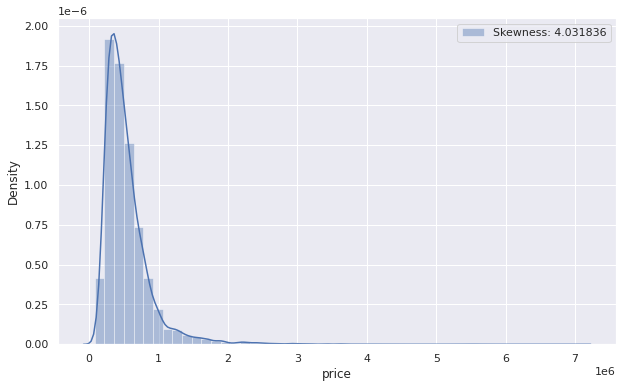

In [ ]:
# 기존의 Skewness(비대칭도), Kurtosis plot(첨도, 뾰족한정도) at train_data
# Skewness 음수인경우 좌측으로 치우침 (Lefe-skewed)
# Kurtosis 값이 클수록 뾰족한 모양을 가짐 (고첨 혹은 첨용) // 0보다 작으면 정규분포보다 낮아짐 (저첨) 

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_data["price"], color = "b", label="Skewness: {:2f}".format(train_data["price"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train_data["price"].skew())
print("Kurtosis: %f" % train_data["price"].kurt())

Skewness: 0.430688
Kurtosis: 0.683231


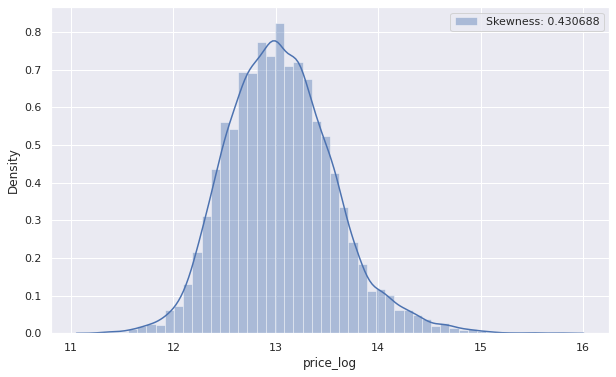

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Log를 취해줌 (Log transform)
# 데이터분포에 Log를 취한 후 Skewness, Kurtosis plot

train_data["price_log"] = train_data["price"].map(lambda i:np.log(i) if i>0 else 0)
# map에서 받은 함수는 np.log(i)
# i가 0보다 큰경우만 받음 // 아닌경우 0을 대입

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_data["price_log"], color = "b", label="Skewness: {:2f}".format(train_data["price_log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train_data['price_log'].skew())
print("Kurtosis: %f" % train_data['price_log'].kurt())

Skewness: 1.646368
Kurtosis: 5.828653


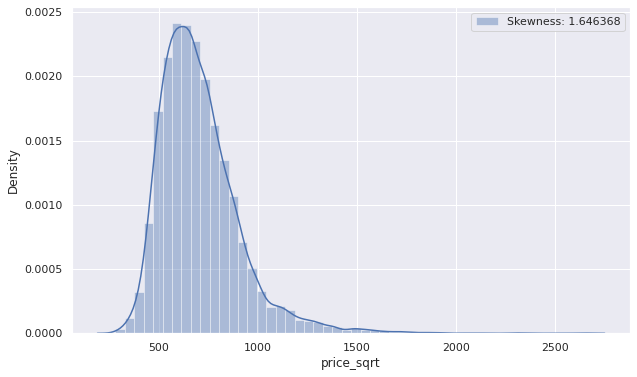

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Square Root를 취해줌 (Square Root transform)
# 데이터분포에 Square Root를 취한 후 Skewness, Kurtosis plot

train_data["price_sqrt"] = train_data["price"].map(lambda i:np.sqrt(i) if i>0 else 0)
# map에서 받은 함수는 np.log(i)
# i가 0보다 큰경우만 받음

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_data["price_sqrt"], color = "b", label="Skewness: {:2f}".format(train_data["price_sqrt"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train_data['price_sqrt'].skew())
print("Kurtosis: %f" % train_data['price_sqrt'].kurt())

Skewness: -0.011665
Kurtosis: 0.295243


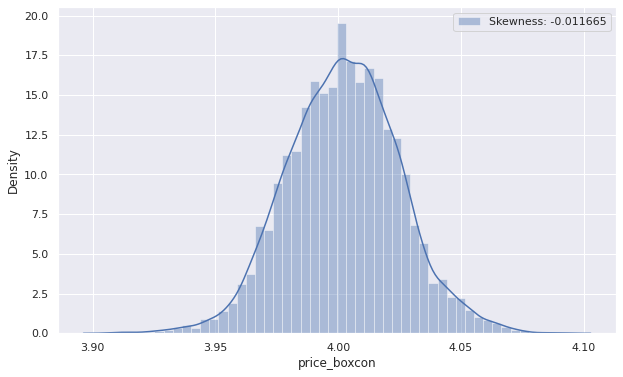

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Box-Cox 취해줌 (Box-Cox transform)
# 데이터분포에 Box-Cox를 취한 후 Skewness, Kurtosis plot
# Skewness / Kurtosis 부분 많이 개선되어짐 (Log, Sqaure root 보다 좋은 결과를 보여줌)
# Range 너무 좁아짐 & Test data 출력시 boxcon 이용한 결과 복원할 방법을 모르겠음

import scipy
from scipy import stats

train_data["price_boxcon"] = pd.Series(stats.boxcox(train_data["price"])[0])

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_data["price_boxcon"], color = "b", label="Skewness: {:2f}".format(train_data["price_boxcon"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train_data['price_boxcon'].skew())
print("Kurtosis: %f" % train_data['price_boxcon'].kurt())

In [ ]:
# 삭제할 데이터부분 선택
train_data.drop('price', axis= 1, inplace=True)
train_data.drop('price_sqrt', axis= 1, inplace=True)
train_data.drop('price_boxcon', axis= 1, inplace=True)

Skewness: 3.305983
Kurtosis: 18.515776


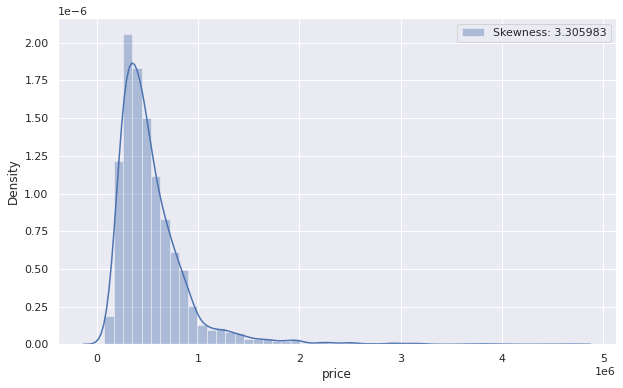

In [ ]:
# 기존의 Skewness, Kurtosis plot (val data set)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(val_data["price"], color = "b", label="Skewness: {:2f}".format(val_data["price"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % val_data["price"].skew())
print("Kurtosis: %f" % val_data["price"].kurt())

Skewness: 0.404180
Kurtosis: 0.613291


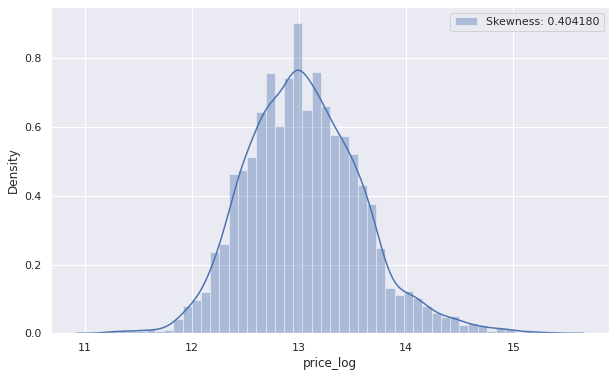

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Log를 취해줌 (정규 근사화)
# 데이터분포에 Log를 취한 후 Skewness, Kurtosis plot

val_data["price_log"] = val_data["price"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(val_data["price_log"], color = "b", label="Skewness: {:2f}".format(val_data["price_log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % val_data['price_log'].skew())
print("Kurtosis: %f" % val_data['price_log'].kurt())

Skewness: 1.555772
Kurtosis: 4.565965


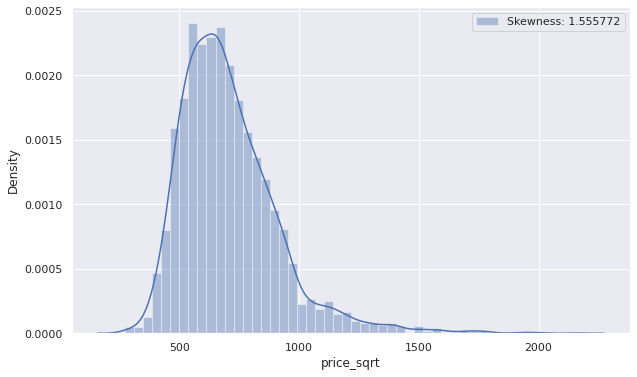

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Square Root를 취해줌 (Square Root transform)
# 데이터분포에 Square Root를 취한 후 Skewness, Kurtosis plot

val_data["price_sqrt"] = val_data["price"].map(lambda i:np.sqrt(i) if i>0 else 0)
# map에서 받은 함수는 np.log(i)
# i가 0보다 큰경우만 받음

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(val_data["price_sqrt"], color = "b", label="Skewness: {:2f}".format(val_data["price_sqrt"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % val_data['price_sqrt'].skew())
print("Kurtosis: %f" % val_data['price_sqrt'].kurt())

Skewness: -0.012167
Kurtosis: 0.341384


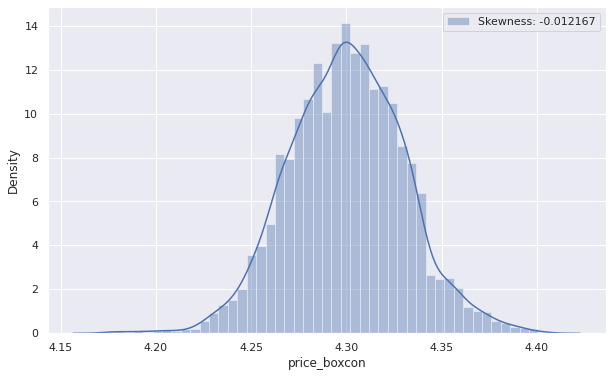

In [ ]:
# 비대칭성과 첨도 해결해주기 위해서 데이터 분포에 Box-Cox 취해줌 (Box-Cox transform)
# 데이터분포에 Box-Cox를 취한 후 Skewness, Kurtosis plot

import scipy
from scipy import stats

val_data["price_boxcon"] = pd.Series(stats.boxcox(val_data["price"])[0])

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(val_data["price_boxcon"], color = "b", label="Skewness: {:2f}".format(val_data["price_boxcon"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % val_data['price_boxcon'].skew())
print("Kurtosis: %f" % val_data['price_boxcon'].kurt())

In [ ]:
# 삭제할 데이터부분 선택
val_data.drop('price', axis= 1, inplace=True)
val_data.drop('price_sqrt', axis= 1, inplace=True)
val_data.drop('price_boxcon', axis= 1, inplace=True)

In [ ]:
# 결측 데이터 처리 (NaN 데이터 포함된 데이터를 처리하는 과정)
# price 데이터는 빼야됨 (포함되어있으면 코드 실행 에러남)

cols_fillna = ['id', 'bedrooms', 'bathrooms', 
               'sqft_living', 'sqft_lot', 'floors', 'waterfront',
               'view', 'condition', 'grade', 'sqft_above',
               'sqft_basement','yr_built', 'yr_renovated',
               'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date']

for col in cols_fillna:
    train_data[col].fillna('None',inplace=True)
    test_data[col].fillna('None',inplace=True)
    val_data[col].fillna('None',inplace=True)

In [ ]:
# 결측 데이터 확인 (Train data set)

total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(21)

,Total,Percent
price_log,0,0.0
condition,0,0.0
date,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0
floors,0,0.0
waterfront,0,0.0
view,0,0.0


In [ ]:
# 결측 데이터 확인 (val data set)

total = val_data.isnull().sum().sort_values(ascending=False)
percent = (val_data.isnull().sum()/val_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(21)

,Total,Percent
price_log,0,0.0
condition,0,0.0
date,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0
floors,0,0.0
waterfront,0,0.0
view,0,0.0


In [ ]:
train_data.isnull().sum().sum(), val_data.isnull().sum().sum(),  test_data.isnull().sum().sum()
# test set의 Price부분이 NaN 되어있는것 빼고 나머지 0

(0, 0, 4322)

In [ ]:
# price와 상관관계가 약한 변수 삭제

id_test = test_data['id']

drop_feature = Weak_features + Date_feature

cols_to_drop = ['id'] + drop_feature

for data in [train_data, test_data, val_data]:
    data.drop(cols_to_drop, inplace= True, axis = 1)

In [ ]:
# Log Transform 사용할 경우
x_tr = train_data.drop("price_log", axis = 1).values
y_tr = train_data["price_log"].values
x_val = val_data.drop("price_log", axis = 1).values
y_val = val_data["price_log"].values

# Square Root Transform 사용할 경우
#x_tr = train_data.drop("price_sqrt", axis = 1).values
#y_tr = train_data["price_sqrt"].values
#x_val = val_data.drop("price_sqrt", axis = 1).values
#y_val = val_data["price_sqrt"].values

# Boxcon Transform 사용할 경우
#x_tr = train_data.drop("price_boxcon", axis = 1).values
#y_tr = train_data["price_boxcon"].values
#x_val = val_data.drop("price_boxcon", axis = 1).values
#y_val = val_data["price_boxcon"].values

x_test = test_data.drop("price", axis = 1).values

# 3. Prediction model 평가

- 모델을 사용하여 결과 출력,좋은결과를 보인 모델을 토대로 모델 선택

In [1]:
# Scikit-learn과 XGBoost 사용

import xgboost as xgboost
from sklearn import metrics

In [ ]:
# Parameter 찾을때만 사용

# 임의 탐색 (Random search)

#from sklearn.model_selection import RandomizedSearchCV

#parameters = {'learning_rate': np.arange(0.001, 0.1, 0.001),
#              'n_estimators':  np.arange(100, 4000, 500),
#              'min_child_weight' : np.arange(1, 5, 1)}

#xgboost = xgboost.XGBRegressor()

#model_xgboost = RandomizedSearchCV(estimator=xgboost,
#                                   param_distributions=parameters,
#                                   scoring='neg_mean_squared_error', n_jobs=4,
#                                   return_train_score = True, random_state=5,
#                                   n_iter=50, verbose = 5)

#print("\m", model_xgboost.fit(x_tr, y_tr))
#print("\n" "Best parameters:", model_xgboost.best_params_)
#print("\n" "Lowest RMSE: ", (-model_xgboost.best_score_)**(1/2.0))

#print(model_xgboost.best_estimator_)
# 가장 나은 parameter set을 출력해줌

In [ ]:
# Reference
#regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.1, min_child_weight = 1.8,
#                                 max_depth= 3, subsample = 0.52, n_estimators = 2000, random_state= 7, ntrhead = -1)

# 임의로 변경시킨 값
#regressor = xgboost.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.016, min_child_weight = 2,
#                                 max_depth= 3, subsample = 0.5, n_estimators = 3000, random_state= 5)

# 1번째 random 변수 최적화로 얻어낸 결과
#regressor = xgboost.XGBRegressor(colsample_bytree = 0.811, colsample_byvel = 0.671, learning_rate = 0.02,
#                                 max_depth= 18, subsample = 0.7, n_estimators = 2400, random_state= 3, ntrhead = -1)

# 2번째 random 변수 최적화로 얻어낸 결과
#regressor = xgboost.XGBRegressor(colsample_bytree = 0.811, colsample_byvel = 0.671, learning_rate = 0.02, min_child_weight = 6.4,
#                                 max_depth= 18, subsample = 0.6, n_estimators = 1500, random_state= 3, ntrhead = -1)

# 2번째 random 변수 최적화로 얻어낸 결과 + 임의로 값 변경
#regressor = xgboost.XGBRegressor(colsample_bytree = 0.8,  colsample_byvel = 0.671, learning_rate = 0.02, min_child_weight = 6.5,
#                                 max_depth= 18, subsample = 0.6, n_estimators = 1500, random_state= 3, ntrhead = -1)

# 3번째 random 변수 최적화로 얻어낸 결과
regressor = xgboost.XGBRegressor(max_depth = 8, learning_rate = 0.01, n_estimators = 1600 , random_state = 5, min_child_weight = 2)

# learning_rate 증가시킬수록 Training set과 validation set의 score 차이 증가
# colsample_bytree 증가시킬수록 Training set score 감소

print(regressor.fit(x_tr,y_tr))
print(regressor.score(x_tr,y_tr))
print(regressor.score(x_val,y_val))

In [ ]:
y_hat = regressor.predict(x_tr)

plt.scatter(y_tr, y_hat, alpha = 0.05)
plt.title('Training Result',size=20) 
plt.xlabel('Targets (y_tr)',size=15) 
plt.ylabel('Predictions (y_hat)',size=15) 
plt.show()

In [ ]:
# data 부분적으로 출력해서 보기위해 .csv 파일로 저장

yy_tr =  np.exp(y_tr)
yy_hat =  np.exp(y_hat)

yy = (yy_tr - yy_hat)
yy_percent = (yy_tr - yy_hat)/yy_tr

target = pd.DataFrame(yy_tr, columns=['target']).to_csv('target.csv')
prediction = pd.DataFrame(yy_hat, columns=['predictions']).to_csv('prediction.csv')
minus = pd.DataFrame(yy, columns=['minus']).to_csv('minus.csv')
percent = pd.DataFrame(yy_percent, columns=['percent']).to_csv('percent.csv')

In [ ]:
# Mean Square Error
mse = metrics.mean_squared_error(y_tr, y_hat)

# Root Mean Square Error
import math
rmse = math.sqrt((metrics.mean_squared_error(y_tr, y_hat)))

print('mse is :', mse, ' rmse is :', rmse)

In [ ]:
y_hat_val = regressor.predict(x_val)

plt.scatter(y_val, y_hat_val, alpha=0.05)
plt.title('Validation Result',size=20) 
plt.xlabel('Targets (y_val)',size=15)
plt.ylabel('Predictions (y_hat_val)',size=15)
plt.show()

In [ ]:
# Mean Square Error
mse = metrics.mean_squared_error(y_val, y_hat_val)

# Root Mean Square Error
import math
rmse = math.sqrt((metrics.mean_squared_error(y_val, y_hat_val)))

print('mse is :', mse, ' rmse is :', rmse)

In [ ]:
# Cross Validation Score 수행 (Validation data set 으로 수행)
# regressor를 강화하는 과정
# 데이터가 독립적이고 동일한 분포를 가진경우이기 때문에 KFold 사용
# 동일 분포 : 추출한 확률 표본이 같은 모집단에서 추출되었다는 의미

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

def abs_error(y_predict, y_real):
    y_real, y_predict = np.array(y_real), np.array(y_predict)
    return np.mean(np.abs((y_real - y_predict) / y_real)) * 100

def rmse_scoring(y_predict, y_real):
  rmse = np.sqrt(mean_squared_error(y_predict,y_real))
  r2 = r2_score(y_predict,y_real)
  mape = abs_error(y_predict, y_real)

  return rmse

kfold = KFold(n_splits=10, shuffle = True, random_state=0)

score = cross_val_score(estimator = regressor, X = x_val, y = y_val, scoring = make_scorer(rmse_scoring,greater_is_better=False), cv = kfold)
print(score.mean())
print(score.std())

[15:10:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print(regressor.score(x_tr,y_tr))
print(regressor.score(x_val,y_val))

-0.21347649143025516
0.009544893880895883



0.9137652702532616
0.8509287655782051


In [ ]:
use_logvals = 1

pred_xgb = regressor.predict(x_test)

sub_xgb = pd.DataFrame()
sub_xgb['id'] = id_test
sub_xgb['price'] = pred_xgb

if use_logvals == 1:
# Log transform 일때
    sub_xgb['price'] = np.exp(sub_xgb['price'])

# Square Root Transform 일때
#    sub_xgb['price'] = (sub_xgb['price'])**2

sub_xgb.to_csv('Submission.csv',index=False)
# 13은 floor(0.2이상 상관계수 가진것 포함)
# 14는 Cross validation score 이용해서 data 다듬음

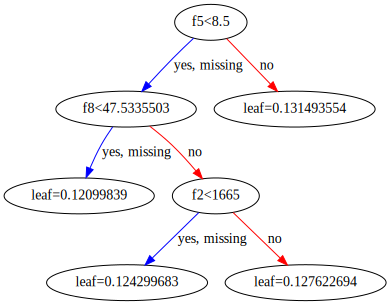

In [ ]:
# XGBoost 모형 출력

import graphviz

data = xgboost.to_graphviz(regressor)
graph=graphviz.Source(data)
graph

In [4]:
!git clone https://github.com/gistvisionclassroom/ca1-20204005.git

Cloning into 'ca1-20204005'...
fatal: could not read Username for 'https://github.com': No such device or address


In [6]:
!ls -ltr

total 4
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data
